## Active Learning Practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline  

In [2]:
train_data = pd.read_csv('train.txt', header=None, sep='\s+')

In [3]:
train_data

,0,1,2,3,4,5,6,7,8,9,10
0,2.793500e+08,3.931456,4.217862,1.268965,1.847527,0.819137,0.115316,0.922267,0.662714,0.127781,4.311178
1,7.697506e+03,1.539552,4.660658,2.179548,4.921036,1.566572,1.558366,2.389427,2.193829,3.786221,3.466104
2,-3.490612e+00,0.910655,0.500066,1.584389,2.888609,4.836919,4.611430,2.913909,4.055956,2.388656,0.699146
3,4.699868e+01,4.730369,0.652626,1.066250,0.891923,2.586304,1.306838,4.209814,3.795288,0.892617,3.198111
4,3.266208e+00,1.640523,0.311214,2.646636,1.759697,1.440362,1.704127,3.721208,2.415884,0.351363,4.695701
...,...,...,...,...,...,...,...,...,...,...,...
95,3.299704e+02,2.589254,1.808863,1.216696,2.238288,2.316360,3.768493,1.024336,1.671272,2.822060,4.527675
96,6.274191e+05,4.121297,2.610305,3.958802,4.152669,3.130992,1.780346,0.545776,3.497756,4.874497,4.121066
97,9.065064e+01,3.243369,0.980290,2.871582,4.603851,3.689643,2.772681,2.484551,1.593578,1.259575,1.496032
98,2.038191e+04,4.703353,1.666714,3.333429,3.686068,4.213608,0.168038,0.772395,3.387421,0.548422,4.919711


Судя по виду первого столбца, это и есть таргет.

In [4]:
test_data = pd.read_csv('test.txt', header=None, sep='\s+')

In [5]:
test_data

,0,1,2,3,4,5,6,7,8,9,10
0,4.535080e+01,2.407947,1.115539,2.670818,1.110434,4.000632,3.183869,3.294535,1.042834,4.314251,4.286058
1,3.910096e+05,2.600747,4.059113,2.436802,2.256467,3.361910,0.675980,2.863344,4.982798,4.384951,4.024604
2,2.474365e+06,2.964418,4.131179,2.037802,3.676861,2.662745,4.205624,0.661382,4.897287,3.829220,1.453527
3,-1.791740e+00,0.128202,2.270797,4.708312,1.374303,2.150640,1.515931,3.033322,4.227080,0.079489,0.732513
4,1.336830e+02,1.077378,3.275785,3.178952,1.289901,2.667271,4.754457,2.790970,3.112239,2.886439,2.290517
...,...,...,...,...,...,...,...,...,...,...,...
24995,1.198084e+03,1.349426,3.996700,3.189764,2.137337,2.855957,2.707567,3.673492,3.411638,0.658873,2.680239
24996,4.378606e+06,2.785103,4.462842,4.197775,1.106668,4.861023,4.091410,3.103792,4.890965,2.882640,0.861522
24997,1.336510e+02,1.340638,2.759771,1.960954,4.555867,4.296282,3.333299,1.565388,4.105293,3.682654,1.346229
24998,2.579348e+08,3.256478,4.926050,3.731281,2.715203,3.011494,4.378854,2.634162,2.629307,1.037093,1.114475


In [6]:
data = np.concatenate((train_data, test_data), axis=0)
mask = np.full(data.shape[0], False)
mask[:train_data.shape[0]] = True

In [7]:
def get_plot(cnt, losses, step=100):
    
    fig = plt.figure(figsize=(20, 5))
    plt.plot(cnt[-step:], losses[-step:], label='Test', color='crimson')
    plt.ylabel('RMSE')
    plt.xlabel('Number of added points')
    plt.title('RMSE to AL Iter')
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [9]:
class ActiveLearner:
    def __init__(self, comittee_size=5, max_size=300, cnt=20, base_model=DecisionTreeRegressor,
                 data=data, mask=mask, loss=root_mean_squared_error):
        self.comittee_size = comittee_size
        self.comittee = [base_model() for _ in range(comittee_size)]
        self.data = data
        self.mask = mask
        self.cnt = cnt
        self.indexes = np.arange(data.shape[0])
        self.size = None
        self._was_more = False
        self.max_size = max_size
        self.loss = loss
    
    def fit(self):
        for estimator in self.comittee:
            indexes = self.generate_random_points()
            train_ = self.data[indexes]
            X_train = train_[:, 1:]
            y_train = train_[:, 0]
            estimator.fit(X_train, y_train)
    
    def generate_random_points(self):
        if not self._was_more:
            size = self.mask.sum()
            if size < self.max_size:
                self.size = size
            else:
                self.size = self.max_size
                self._was_more = True
        choice = np.random.choice(self.indexes[self.mask], self.size, replace=False)
        return choice
    
    def add_new_point(self):
        indexes_ = self.indexes[~self.mask]
        X_test = self.data[indexes_][:, 1:]
        variance = np.var([self.comittee[i].predict(X_test)
                           for i in range(self.comittee_size)], axis=0)
        worst = np.argsort(variance)[-self.cnt:]
        self.mask[indexes_[worst]] = True
    
    def get_train_test(self):
        train_ = self.data[self.mask]
        test_ = self.data[~self.mask]
        return train_[:, 1:], train_[:, 0], test_[:, 1:], test_[:, 0]


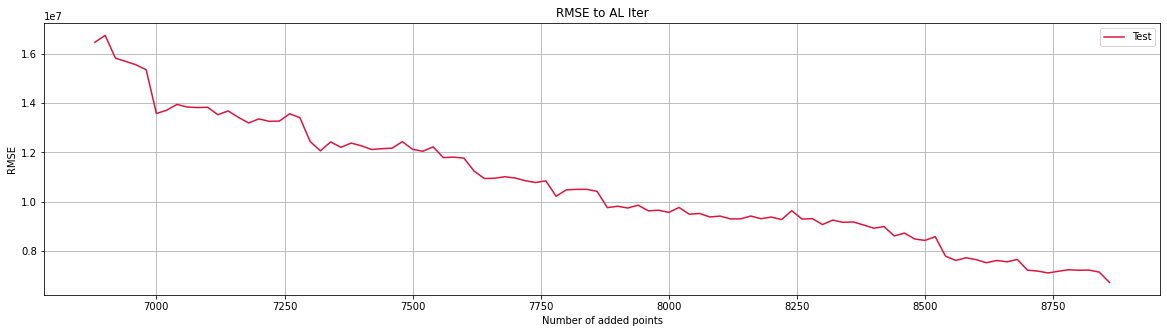

In [10]:
al = ActiveLearner()
losses = []
cnt = []

for i in range(test_data.shape[0]//(3*(al.cnt-1))):
    model = RandomForestRegressor(n_estimators=500, max_depth=30, n_jobs=-1)
    al.fit()
    al.add_new_point()
    X_train, y_train, X_test, y_test = al.get_train_test()
    model.fit(X_train, y_train)
    losses.append(root_mean_squared_error(y_test, model.predict(X_test)))
    cnt.append(X_train.shape[0])
    if i % 100 == 1:
        clear_output(True)
        get_plot(cnt, losses)

clear_output(True)
get_plot(cnt, losses)

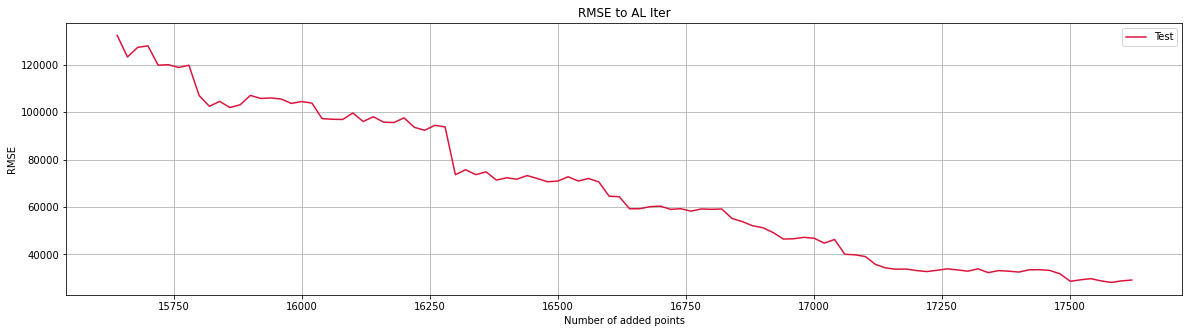

In [11]:
for i in range(test_data.shape[0]//(3*(al.cnt-1))):
    model = RandomForestRegressor(n_estimators=500, max_depth=30, n_jobs=-1)
    al.fit()
    al.add_new_point()
    X_train, y_train, X_test, y_test = al.get_train_test()
    model.fit(X_train, y_train)
    losses.append(root_mean_squared_error(y_test, model.predict(X_test)))
    cnt.append(X_train.shape[0])
    if i % 100 == 1:
        clear_output(True)
        get_plot(cnt, losses)

clear_output(True)
get_plot(cnt, losses)

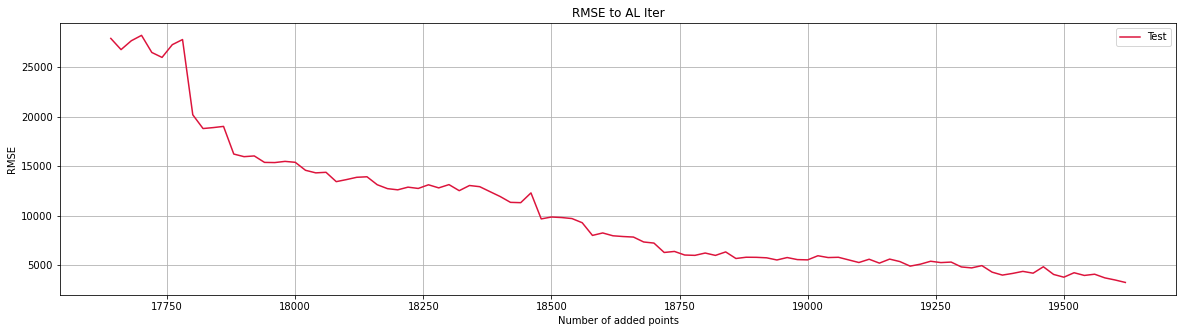

In [12]:
for i in range(100):
    model = RandomForestRegressor(n_estimators=500, max_depth=30, n_jobs=-1)
    al.fit()
    al.add_new_point()
    X_train, y_train, X_test, y_test = al.get_train_test()
    model.fit(X_train, y_train)
    losses.append(root_mean_squared_error(y_test, model.predict(X_test)))
    cnt.append(X_train.shape[0])
    if i % 100 == 1:
        clear_output(True)
        get_plot(cnt, losses)

clear_output(True)
get_plot(cnt, losses)